# Continuous Control

---

In this notebook, we will train an RL agent how to controll a double-jointed arm, to reach target locations using DDPG.


### 1. Import packages


As we will start the environment please change the `file_name` parameter to match the location of the Unity environment that you downloaded. 
This solution applies to the signle agent version of the reacher environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np


env = UnityEnvironment(file_name='Reacher_Linux_2nd/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. 

Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print("Using {}".format(brain_name))

Using ReacherBrain


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. Train the Agents with DDPG

Run the code cells below to train the agents. 


In [4]:
import datetime
from itertools import count
import torch
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import time
%matplotlib inline

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [6]:
def ddpg(n_episodes=1000, max_t=500):
    avg_score = []
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    time_steps = 20
    update = 10
    
    env_info = env.reset(train_mode=True)[brain_name]
    
    states = env_info.vector_observations
    
    agent_tuple = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_tuple) for _ in range(num_agents)]
    action = [agent.act(states[i]) for i, agent in enumerate(agents)]   
    
    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations                 
        for agent in agents:
            agent.reset()

        for t in range(max_t):
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                       
            
            step_t = zip(agents, states, actions, rewards, next_states, dones)
            
            for agent, state, action, reward, next_step, done in step_t:
                agent.memory.add(state, action, reward, next_step, done)
                if ( t % time_steps == 0):
                    agent.step(state, action, reward, next_step, done, update)
            states  = next_states
            scores += rewards                                  
            if np.any(dones):                                 
                break
                
        score = np.mean(scores)        
        avg_score.append(score)
        scores_deque.append(score)
        avg = np.mean(scores_deque)            
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg,), end="\n")

        if np.mean(scores_deque) > 30.:
            print("\r\rEnviroment solved in @ i_episode={i_episode}, w/ avg_score={avg:.2f}\r".format(i_episode=i_episode, avg=avg))

            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
            break
    
    return avg_score



In [7]:
scores = ddpg()

Episode 1	Average Score: 0.13
Episode 2	Average Score: 0.24
Episode 3	Average Score: 0.28
Episode 4	Average Score: 0.33
Episode 5	Average Score: 0.38
Episode 6	Average Score: 0.42
Episode 7	Average Score: 0.45
Episode 8	Average Score: 0.49
Episode 9	Average Score: 0.51
Episode 10	Average Score: 0.54
Episode 11	Average Score: 0.56
Episode 12	Average Score: 0.58
Episode 13	Average Score: 0.61
Episode 14	Average Score: 0.63
Episode 15	Average Score: 0.64
Episode 16	Average Score: 0.66
Episode 17	Average Score: 0.68
Episode 18	Average Score: 0.70
Episode 19	Average Score: 0.71
Episode 20	Average Score: 0.73
Episode 21	Average Score: 0.74
Episode 22	Average Score: 0.76
Episode 23	Average Score: 0.78
Episode 24	Average Score: 0.79
Episode 25	Average Score: 0.81
Episode 26	Average Score: 0.83
Episode 27	Average Score: 0.84
Episode 28	Average Score: 0.86
Episode 29	Average Score: 0.88
Episode 30	Average Score: 0.89
Episode 31	Average Score: 0.91
Episode 32	Average Score: 0.93
Episode 33	Averag

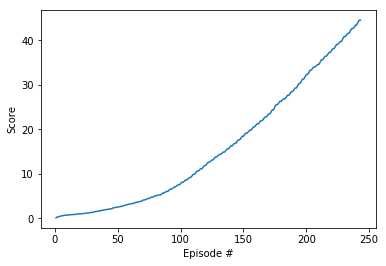

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig("scoreoverepisodes.jpg")

When finished, you can close the environment.

In [10]:
env.close()